In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 487.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompati

In [1]:
import gensim
gensim.__version__

'4.3.3'

In [2]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 kB 24.2 MB/s eta 0:00:00


## 1. 영어 Word2Vec 만들기

In [3]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [4]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
# 훈련데이터 다운로드 (ted talk script)
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7ff7eae23ed0>)

In [6]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일에서 추출한 text로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 '문장' 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 '단어' 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [7]:
print('총 샘플(문장)의 개수 : {}'.format(len(result)))

총 샘플(문장)의 개수 : 273424


In [8]:
# 샘플(문장) 3개만 출력해서 토큰화된 단어 확인
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [9]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

- `vector_size` = 임베딩 된 벡터의 차원.
- `window` = 컨텍스트 윈도우 크기
- `min_count` = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- `workers` = 학습을 위한 프로세스 수
- `sg` = 0은 CBOW, 1은 Skip-gram.

CBOW는 target word 근처의 문맥을 파악하여 target word를 예측하는 방법이고, Skip-gram은 target word를 보고 문맥을 예측하는 방법입니다. `window`란 인자는 근처 문맥의 단어를 몇개로 할지 그 크기를 설정하는 인자입니다.

![neural language model vs word2vec](https://user-images.githubusercontent.com/115082062/213910013-2c91f210-090d-47f7-b842-33f64a3b2c50.png)


In [10]:
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

`model.wv.most_similar()`를 통해 입력한 단어와 가장 유사한 단어를 출력할 수 있습니다. 코사인 유사도를 기반으로 출력해줍니다.
원하는 단어를 input으로 넣어보세요!

In [11]:
model_result = model.wv.most_similar("ball")
print(model_result)

[('balloon', 0.8169201612472534), ('glass', 0.8075274229049683), ('rope', 0.8031749725341797), ('rock', 0.801403820514679), ('horse', 0.7591930031776428), ('plane', 0.7569096088409424), ('wall', 0.755211353302002), ('hole', 0.7522233724594116), ('bag', 0.746631920337677), ('button', 0.743503212928772)]


유사도를 기반으로 산정된 벡터들이기 때문에 연산도 가능합니다.

In [12]:
model.wv.most_similar(positive=['woman'], negative=['man'])

[('failed', 0.34371110796928406),
 ('sex', 0.32661929726600647),
 ('cancer', 0.3113265931606293),
 ('her', 0.3084467947483063),
 ('child', 0.30439677834510803),
 ('graduate', 0.29068729281425476),
 ('male', 0.2903099060058594),
 ('trained', 0.28954756259918213),
 ('newborn', 0.2880638837814331),
 ('patient', 0.285386860370636)]

In [13]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [14]:
model_result = loaded_model.most_similar("ball")
print(model_result)

[('balloon', 0.8169201612472534), ('glass', 0.8075274229049683), ('rope', 0.8031749725341797), ('rock', 0.801403820514679), ('horse', 0.7591930031776428), ('plane', 0.7569096088409424), ('wall', 0.755211353302002), ('hole', 0.7522233724594116), ('bag', 0.746631920337677), ('button', 0.743503212928772)]


## 2. 한국어 Word2Vec 만들기

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
import tqdm

In [16]:
# 네이버 영화 리뷰 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7ff7cc686e10>)

In [17]:
train_data = pd.read_table('ratings.txt')

In [18]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [19]:
print(len(train_data))

200000


In [20]:
train_data.info() # 결측값이 존재하는 행 8개 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [21]:
train_data = train_data.dropna(how = 'any') # 결측 값 존재하는 행 제거

In [22]:
print(len(train_data)) # 8개 행이 사라짐

199992


In [23]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [24]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [25]:
from google import colab
colab.drive.mount("/content/drive")

Mounted at /content/drive


In [46]:
# 불용어 리스트 정의
with open('/content/stopword.txt',  encoding='utf-8') as f:
    list_file = f.readlines()
    stopwords = list_file[0].split(",")

okt를 사용할 경우 20분 내외의 런타임이 소요됩니다.

In [30]:
# using okt
okt = Okt()

tokenized_data = []
for sentence in tqdm.tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [14:45<00:00, 225.85it/s]


In [31]:
# 리뷰 3개의 토큰화 결과만 출력
print(tokenized_data[:3])

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '을', '배우다', '학생', '으로', ',', '외국', '디자이너', '와', '그', '들', '이', '일군', '전통', '을', '통해', '발전', '하다', '문화', '산업', '이', '부럽다', '.', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '에', '끝', '까지', '열정', '을', '지키다', '노라노', '같다', '전통', '이', '있다', '저', '와', '같다', '사람', '들', '이', '꿈', '을', '꾸다', '이루다', '나가다', '수', '있다', '것', '에', '감사하다', '.'], ['폴리스스토리', '시리즈', '는', '1', '부터', '뉴', '까지', '버리다', '하나', '도', '없다', '..', '최고', '.']]


- 왜 불용어 제거가 안 됐지??

In [47]:
stopwords

['않다\n']

stopword.txt가 이상하게 불러와진듯

In [57]:
with open('/content/stopword.txt',  encoding='utf-8') as f:
    list_file = f.readlines()
    stopwords = [word.strip() for word in list_file]


In [60]:
stopwords[:5]

['않다', '되어다', '되다', '하다', '어떻다']

### 불용어 제대로 제거 안 됐을 때

리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 14.386465458618344


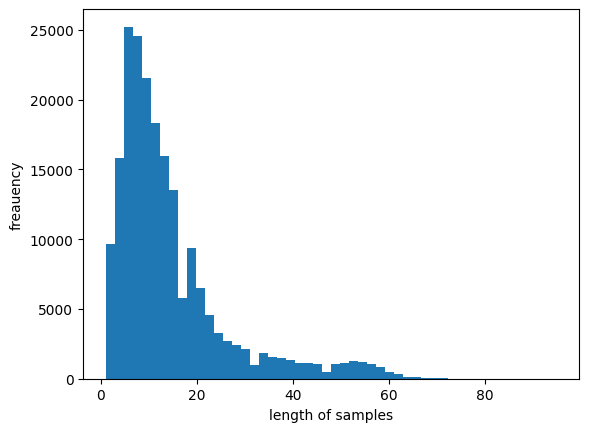

In [59]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('freauency')
plt.show()

In [33]:
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [34]:
model.wv.vectors.shape # 총 17806개의 단어가 100차원으로 구성되어있음.

(17633, 100)

In [35]:
print(model.wv.most_similar("이동진"))

[('김혜리', 0.7698833346366882), ('진미', 0.7678743600845337), ('****', 0.7653688788414001), ('허지웅', 0.7490495443344116), ('이용철', 0.7341283559799194), ('아랫', 0.7224571704864502), ('악플달다', 0.7184157967567444), ('창정', 0.7159080505371094), ('쌩', 0.7109512090682983), ('쿠스', 0.710426390171051)]


In [36]:
model.wv.most_similar(positive=['타짜'])

[('행오버', 0.785232663154602),
 ('km', 0.7816333174705505),
 ('맞짱', 0.7773083448410034),
 ('데스티네이션', 0.776935875415802),
 ('번개', 0.7763634920120239),
 ('REC', 0.7762849926948547),
 ('람보', 0.7749783396720886),
 ('전투기', 0.7739260196685791),
 ('경찰차', 0.7736965417861938),
 ('동방불패', 0.7734843492507935)]

In [37]:
model.wv.most_similar(positive=['송강호'], negative=['주연'])

[('토비', 0.48048385977745056),
 ('..!', 0.47534406185150146),
 ('김선아', 0.4651123583316803),
 ('환희', 0.4630357027053833),
 ('에를', 0.460384726524353),
 ('아하', 0.4525896906852722),
 ('안젤리나', 0.4513236880302429),
 ('장쯔이', 0.446704626083374),
 ('이범수', 0.4444981515407562),
 ('So', 0.4435994625091553)]

In [38]:
model.wv.similarity('송강호', '하정우')

0.7881726

In [39]:
model.wv.similarity('송강호', '축구')

0.32574162

In [40]:
model.wv.most_similar(positive=['학생'])

[('젊은이', 0.7517164349555969),
 ('군인', 0.73053377866745),
 ('자녀', 0.730181097984314),
 ('선수', 0.7113862633705139),
 ('미국인', 0.7081536650657654),
 ('시민', 0.6968538761138916),
 ('주민', 0.6817831993103027),
 ('서양인', 0.6801138520240784),
 ('외국인', 0.6726186871528625),
 ('고등학생', 0.669464111328125)]

### 불용어 제거 다시 시도

In [61]:
# using okt
okt = Okt()

tokenized_data = []
for sentence in tqdm.tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [17:45<00:00, 187.73it/s]


In [71]:
# 리뷰 3개의 토큰화 결과만 출력
print(tokenized_data[:3])

[['어리다', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '배우다', '학생', ',', '외국', '디자이너', '일군', '전통', '통해', '발전', '문화', '산업', '부럽다', '.', '사실', '우리나라', '에서도', '어렵다', '시절', '끝', '열정', '지키다', '노라노', '전통', '사람', '꿈', '꾸다', '이루다', '나가다', '수', '감사하다', '.'], ['폴리스스토리', '시리즈', '는', '1', '뉴', '버리다', '도', '없다', '..', '최고', '.']]


리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 11.405576223048921


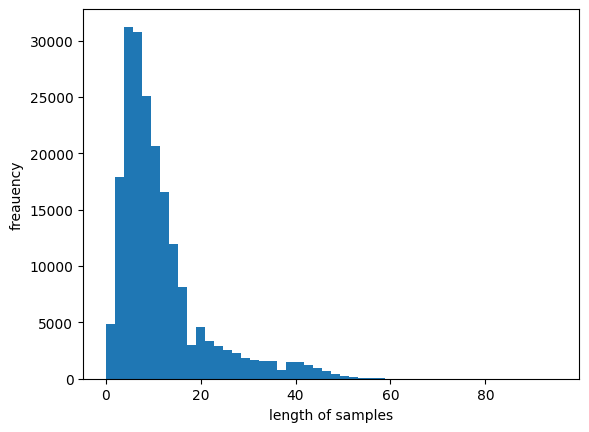

In [62]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('freauency')
plt.show()

In [63]:
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [64]:
model.wv.vectors.shape # 총 17398개의 단어가 100차원으로 구성되어있음.

(17398, 100)

In [65]:
print(model.wv.most_similar("이동진"))

[('김수환', 0.8466683626174927), ('영화평론가', 0.8189653754234314), ('추기경', 0.8120182752609253), ('이태석', 0.8089963793754578), ('한겨레', 0.8087313175201416), ('****', 0.8028573393821716), ('김혜리', 0.801037609577179), ('조형기', 0.7941828370094299), ('병장', 0.7933769226074219), ('스티브잡스', 0.7890301942825317)]


In [66]:
model.wv.most_similar(positive=['타짜'])

[('무법자', 0.8782423138618469),
 ('팩', 0.8692091703414917),
 ('리턴즈', 0.8646606802940369),
 ('조폭마누라', 0.8630024194717407),
 ('논스톱', 0.8567058444023132),
 ('자처', 0.855045735836029),
 ('공공', 0.8530014753341675),
 ('이집트', 0.8518819808959961),
 ('협주곡', 0.8492632508277893),
 ('에이리언', 0.8486129641532898)]

In [67]:
model.wv.most_similar(positive=['송강호'], negative=['주연'])

[('디게', 0.5075719356536865),
 ('커밍아웃', 0.4980399012565613),
 ('gg', 0.4962035119533539),
 ('당돌하다', 0.4945511817932129),
 ('식겁하다', 0.4941502511501312),
 ('거미', 0.4938122034072876),
 ('파도처럼', 0.4916183650493622),
 ('끗', 0.49135610461235046),
 ('력도', 0.49013686180114746),
 ('./', 0.4850049316883087)]

In [68]:
model.wv.similarity('송강호', '하정우')

0.8453602

In [69]:
model.wv.similarity('송강호', '축구')

0.28215578

In [70]:
model.wv.most_similar(positive=['학생'])

[('대통령', 0.7823671698570251),
 ('교회', 0.7576339244842529),
 ('세대', 0.7312204241752625),
 ('젊은이', 0.7254768013954163),
 ('국제', 0.7253022193908691),
 ('선생님', 0.7207458019256592),
 ('국민', 0.7191042304039001),
 ('유학', 0.7118864059448242),
 ('사회생활', 0.6985456347465515),
 ('외국인', 0.6978520750999451)]